## Dependencies

In [17]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [18]:
%matplotlib inline

In [19]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

In [20]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Summary:

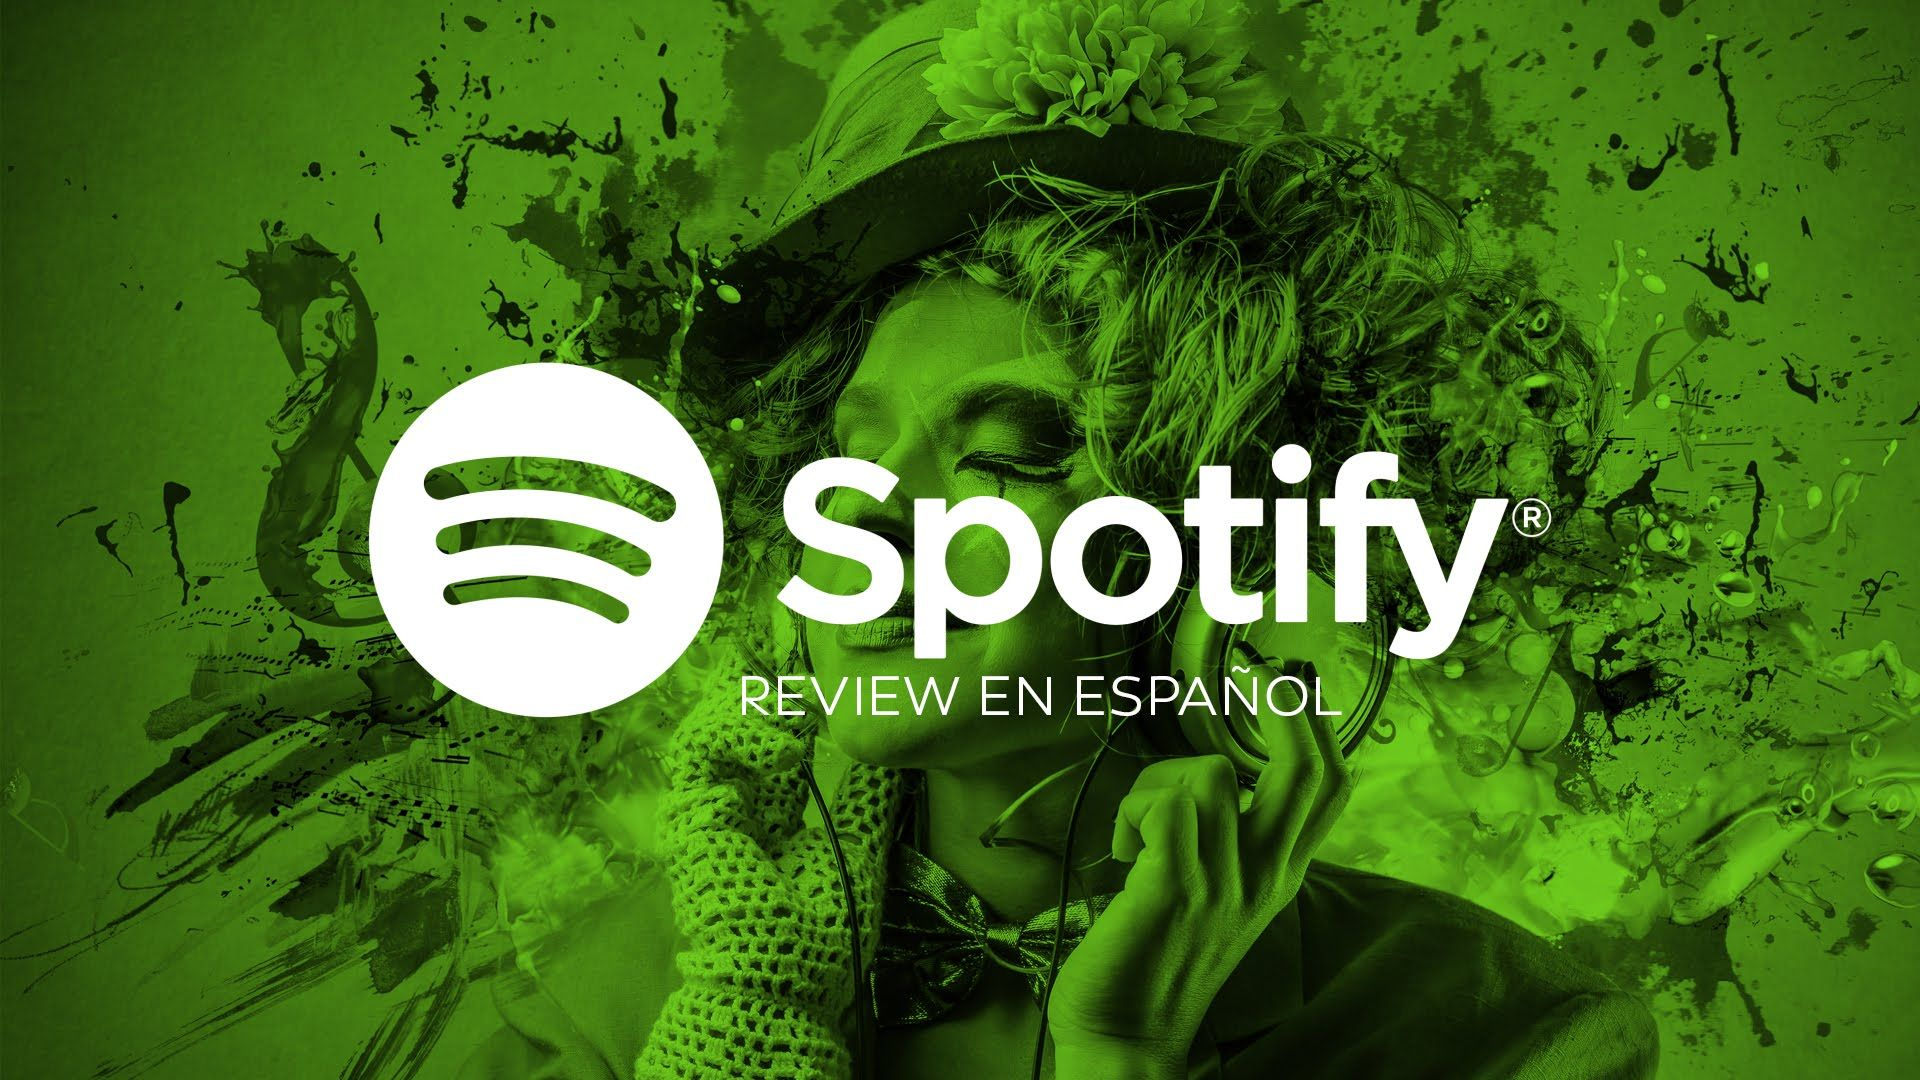

In [21]:
from IPython.display import Image
Image(r"C:\Users\piyus\Downloads\wp9830610.jpg")

## 1. Data Exploration/Preparation

Download datasets here:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [22]:
spotify_df = pd.read_csv(r"C:\Users\piyus\Downloads\SpotifyFeatures.csv\SpotifyFeatures.csv")

In [23]:
spotify_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful but I'll need to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [25]:
data_w_genre = pd.read_csv(r"C:\Users\piyus\Downloads\data_w_genres.csv\data_w_genres.csv")
data_w_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [26]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

This checks whether or not `genres` is actually in a list format:

In [27]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [28]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

As we can see, it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [29]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [30]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

Voila, now we have the genre column in a format we can actually use. If you go down, you'll see how we use it. 

Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:
1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge `data_w_genre` to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

Before I go further, let's complete these two steps.

Step 1. 
Similar to before, we will need to extract the artists from the string list. 

In [33]:
spotify_df['artists_upd_v1'] = spotify_df['artist_name'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [35]:
spotify_df['artist_name'].values[0]

'Henri Salvador'

In [38]:
def get_first_artist(artist_list):
    if isinstance(artist_list, list) and artist_list:
        return artist_list[0]
    return None  # or return '' if you prefer

spotify_df['first_artist'] = spotify_df['artists_upd_v1'].apply(get_first_artist)


This looks good but did this work for every artist string format. Let's double check

In [39]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists_upd_v1,first_artist
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,[],None
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,[],None
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,[],None
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,[],None
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,[],None


So, it looks like it didn't catch all of them and you can quickly see that it's because artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. I'll write another regex to handle this and then combine the two

In [41]:
spotify_df['artists_upd_v2'] = spotify_df['artist_name'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [47]:
def create_song_identifier(row):
    artist = row['artists_upd'][0].strip().lower() if isinstance(row['artists_upd'], list) and row['artists_upd'] else 'unknown_artist'
    name = row['track_name'].strip().lower() if isinstance(row['track_name'], str) else 'unknown_title'
    return f"{artist}_{name}"

spotify_df['artists_song'] = spotify_df.apply(create_song_identifier, axis=1)


In [49]:
spotify_df.sort_values(['artists_song','time_signature'], ascending = False, inplace = True)

In [51]:
spotify_df[spotify_df['artist_name']=='Adore You']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists_upd_v1,first_artist,artists_upd_v2,artists_upd,artists_song


In [52]:
spotify_df.drop_duplicates('track_name',inplace = True)

In [54]:
spotify_df[spotify_df['track_name']=='Adore You']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists_upd_v1,first_artist,artists_upd_v2,artists_upd,artists_song
13819,Dance,Miley Cyrus,Adore You,5AnCLGg35ziFOloEnXK4uu,73,0.111,0.583,278747,0.655,0.000004,C,0.113,-5.407,Major,0.0315,119.759,4/4,0.201,[],None,[],[],unknown_artist_adore you


Now I can explode this column and merge as I planned to in `Step 2`

In [56]:
artists_exploded = spotify_df[['artists_upd','track_id']].explode('artists_upd')

In [57]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [59]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['track_id'] =='6KuQTIu1KoTTkLXKrwlLPV']

,artists_upd,track_id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_upd


Alright we're almost their, now we need to:
1. Group by on the song `id` and essentially create lists lists
2. Consilidate these lists and output the unique values

In [60]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('track_id')['genres_upd'].apply(list).reset_index()

In [61]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [62]:
artists_genres_consolidated.head()

,track_id,genres_upd,consolidates_genre_lists
0,0KVBOePJfYse4RLo6koXTY,"[[cali_rap, trap]]","[cali_rap, trap]"
1,0SVoYMEKJcY56RbGrU5Of5,"[[latin, latin_hip_hop, reggaeton, tropical]]","[tropical, latin_hip_hop, latin, reggaeton]"
2,18GDvs1CYpDCZDPFLLfV8x,"[[bachata, latin, latin_hip_hop, latin_pop, tr...","[trap_latino, latin_pop, bachata, latin_hip_ho..."
3,1RckMJQGm3aOHJIB17wUXm,"[[cali_rap, trap]]","[cali_rap, trap]"
4,1qopcQIJcQofNfS1IF3Phc,"[[cali_rap, trap]]","[cali_rap, trap]"


In [65]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['track_id','consolidates_genre_lists']], on = 'track_id',how = 'left')

## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
### - Create TF-IDF features off of artist genres

In [ ]:
spotify_df.tail()

In [66]:
spotify_df['year'] = spotify_df['time_signature'].apply(lambda x: x.split('-')[0])

In [67]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [68]:
ohe_cols = 'popularity'

In [69]:
spotify_df['popularity'].describe()

count    148615.000000
mean         35.648589
std          17.410018
min           0.000000
25%          24.000000
50%          36.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [70]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [71]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [72]:
spotify_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artists_upd_v1,first_artist,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,year,popularity_red
0,Comedy,"""Weird Al"" Yankovic","Young, Dumb & Ugly",3pL8KCYTMhj94na1xvpiyY,25,0.00437,0.561,264907,0.714,0.000007,B,0.3220,-8.050,Major,0.0295,123.182,4/4,0.613,[],None,[Weird Al],[Weird Al],"weird al_young, dumb & ugly",[],4/4,5
1,Comedy,"""Weird Al"" Yankovic",You Don't Love Me Anymore,4g6D1Lw2iQIk6HXsXc16Zy,31,0.33400,0.462,241040,0.264,0.000000,C#,0.1960,-13.854,Major,0.0319,177.827,4/4,0.543,[],None,[Weird Al],[Weird Al],weird al_you don't love me anymore,[],4/4,6
2,Comedy,"""Weird Al"" Yankovic",Weasel Stomping Day,4PI3sEk50JmiHG5Eh8TqGI,36,0.43200,0.720,94347,0.498,0.000000,D,0.2100,-10.165,Major,0.0363,111.445,4/4,0.957,[],None,[Weird Al],[Weird Al],weird al_weasel stomping day,[],4/4,7
3,Comedy,"""Weird Al"" Yankovic",Velvet Elvis,70PR4QBJsUIcSgSWSNwmRY,20,0.09240,0.597,270440,0.712,0.000000,G,0.0962,-9.737,Major,0.0739,169.454,4/4,0.653,[],None,[Weird Al],[Weird Al],weird al_velvet elvis,[],4/4,4
4,Comedy,"""Weird Al"" Yankovic",Trigger Happy,5iZw9vkowuc2BSJOWXZs7o,28,0.32700,0.618,227373,0.670,0.000000,G#,0.1120,-8.016,Major,0.0357,164.074,4/4,0.978,[],None,[Weird Al],[Weird Al],weird al_trigger happy,[],4/4,5


In [73]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def create_feature_set(df, float_cols):
    # Ensure 'consolidates_genre_lists' exists and is a list of strings
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop=True, inplace=True)

    float_df = df[float_cols].reset_index(drop=True)

    return pd.concat([float_df, genre_df], axis=1)


In [84]:
# Example: list of numerical audio feature columns
float_cols = ['danceability', 'energy', 'valence', 'tempo']  # update this as needed
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)


In [85]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [5]:
#client id and secret for my application
client_id = 'id'
client_secret= 'secret'

In [8]:
import sys

scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    # fallback or prompt
    username = input("Enter Spotify username: ")


In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = 'your_spotify_client_id'
client_secret = 'your_spotify_client_secret'

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)


In [ ]:
import spotipy.util as util

token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

Using 'localhost' as a redirect URI is being deprecated. Use a loopback IP address such as 127.0.0.1 to ensure your app remains functional.


In [ ]:
sp = spotipy.Spotify(auth=token)

In [ ]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [ ]:
id_name

In [ ]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [ ]:
id_name

In [ ]:
playlist_EDM = create_necessary_outputs('EDM', id_name,spotify_df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [ ]:
playlist_EDM

In [ ]:
visualize_songs(playlist_EDM)

## 4. Create Playlist Vector

In [ ]:
from IPython.display import Image
Image(r"C:\Users\piyus\Downloads\summarization_2.png")

In [ ]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [ ]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_EDM, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [ ]:
complete_feature_set_playlist_vector_EDM.shape

## 5. Generate Recommendations

In [ ]:
from IPython.display import Image
Image("/Users/thakm004/Documents/Spotify/cosine_sim_2.png")

In [ ]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [ ]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [ ]:
edm_top40

In [ ]:
visualize_songs(edm_top40)

In [ ]:
chill_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill)